Working notebook for masther thesis

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.io import loadmat
from scipy import stats
import statsmodels.api as sm
plt.style.use("ggplot")  
%matplotlib inline

from scipy.optimize import least_squares

from scipy.special import erf

from concurrent.futures import ProcessPoolExecutor
from typing import Iterable, Tuple, Dict, Optional

from scipy.stats import linregress

from tqdm import tqdm 

import openpyxl

Dataset preparation

In [2]:
mat =loadmat("/Users/davidsandovalrodriguez/Projects/Fund-Kink-Smoothing/data/TFMdata/AllB_JF.mat")

In [3]:
Y     = np.asarray(mat["Y"])       # 540 x 2321
TNA   = np.asarray(mat["TNA"])     # same shape
F     = np.asarray(mat["F"])       # 540 x 5
rf    = np.asarray(mat["rf"]).flatten()  # 540 x 1 → flatten to 1D
style = np.asarray(mat["stylemat"])      # 2321 x 18
fundids = mat["fundids"].flatten()       # 2321 × 1 → fund ID for each column

T, N = Y.shape

# Time and Fund grids
time_idx = np.arange(T)
fund_idx = np.arange(N)

time_grid, fund_grid = np.meshgrid(time_idx, fund_idx, indexing='ij')
df = pd.DataFrame({
    "time": time_grid.ravel(),
    "fund_index": fund_grid.ravel(),
    "fund_id": fundids[fund_grid.ravel()],
    "Y": Y.ravel(),
    "TNA": TNA.ravel(),
    # add more fields if needed (e.g., TNA1, etc.)
})

style_df = pd.DataFrame(style, columns=[f"style_{i+1}" for i in range(style.shape[1])])
style_df["fund_id"] = fundids
df = df.merge(style_df, on="fund_id", how="left")
df.replace(-999, np.nan, inplace=True)
df.shape

F_df = pd.DataFrame(F, columns=[f"F{i+1}" for i in range(F.shape[1])])
F_df["time"] = np.arange(F.shape[0])

# Merge into df
df = df.merge(F_df, on="time", how="left")

df = df.dropna(subset=["Y", "TNA"])
df.shape
df.head()

,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
5,0,5,100010,0.005069,64.361911,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
9,0,9,100019,0.158994,35.243098,0,0,0,1,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
15,0,15,100046,0.091393,57.922143,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
16,0,16,100047,0.135792,58.868593,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
18,0,18,100055,0.141008,3610.879183,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386


In [4]:
df = df.sort_values(["fund_id","time"])  

Linear model

In [135]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    p_values = res.pvalues

    p_value_a = p_values[0]
    p_value_b = p_values[1]
    p_values_betas = p_values[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory,
        "p_value_a": p_value_a,
        "p_value_b":p_value_b
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)





In [136]:
estimates_lin = estimate_all_funds_linear(df)

100%|██████████| 2321/2321 [00:01<00:00, 2206.17it/s]


In [144]:
estimates_lin

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,p_value_a,p_value_b,fund_id
0,0.001492,-2.660309e-07,0.962015,-0.018759,0.051107,0.028328,0.944872,0.036179,386,-2804.264635,1.021136e-01,0.543735,100001
1,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,1.440989e-01,0.674048,100003
2,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,1.846141e-03,0.225668,100004
3,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,4.737384e-08,0.075393,100006
4,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,3.773101e-03,0.274546,100009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,1.149641e-01,0.348898,603104
2317,0.002532,-8.807708e-07,0.899121,0.269719,0.204654,-0.030219,0.888521,0.008236,60,-1437.521256,3.827626e-01,0.938292,603146
2318,-0.002967,-4.924477e-05,1.082990,0.159256,0.228119,-0.043161,0.931297,0.006549,60,30.123806,2.411966e-01,0.157213,603166
2319,0.002993,1.561511e-05,0.782134,-0.087441,0.321272,0.082336,0.872283,0.005384,63,95.829927,2.867118e-01,0.810481,604486


Smoothed model

In [16]:
def S_h_gauss(q, K, h):
    """
    Gaussian CDF smooth step  ≈ 1{q <= K}.
    Vectorised for NumPy arrays.
    """
    z = (K - q) / (np.sqrt(2.0) * h)
    return 0.5 * (1.0 + erf(z))

def alpha_smooth_gauss(a, b, K, q, h):
    S  = S_h_gauss(q, K, h)
    return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)

def residuals(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_smooth_gauss(a, b, K, q, h)  
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y


In [17]:
h_param = 0.001

estimating wrappers

In [18]:
def estimate_one_fund(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:  
        print(q)             # skip tiny time-series
        return None

    fund_id = fund_df["fund_id"].iat[0]
    
    # Look up the linear model's estimates
    linear_estimates = estimates_lin.loc[estimates_lin["fund_id"] == fund_id]

    # Assign the linear estimates to the initial guess variables
    a0 = linear_estimates["a_lin"].iat[0]
    b0 = linear_estimates["b_lin"].iat[0]
    #K0 = linear_estimates["K_the_lin"].iat[0] 

    K0 = max(linear_estimates["K_the_lin"].iat[0], 1e-6)
    
    #a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

# =============================================================
#   Dataset-wide wrapper
# =============================================================
def estimate_all_funds(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates.
    """
    results = []

    # -------- serial with progress bar --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund(g, h)
        if est is not None:
            est["fund_id"] = fid
            results.append(est)

    return pd.DataFrame(results)

estimating wrappers with different initial guess

In [19]:
def estimate_one_fund_guess(fund_df, h=0.01, lin_map=None):
    """
    Non-linear estimator seeded with (a,b) from prior linear fit.
    """
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    msk = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[msk], y[msk], F[msk]
    if len(q) < 24:
        print(q)
        return None                                # skip tiny time series

    # ---------- initial guesses ---------------------------------------
    fid = fund_df["fund_id"].iloc[0]
    if lin_map is not None and fid in lin_map:
        a0 = lin_map[fid]["a"]
        b0 = lin_map[fid]["b"]
    else:                                          # fallback
        a0 = np.mean(y)
        b0 = 0.0

    K0    = np.median(q)                           # still data-driven
    beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

    x0 = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    #uncomment to swtich between algorithms

    #res = least_squares(residuals, x0,
    #                    args=(q, y, F, h), method="lm", max_nfev=4000)
    
    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "fund_id": fid,
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

def estimate_all_funds_guess(df, h=0.01, lin_map=None):
    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        out = estimate_one_fund_guess(g, h=h, lin_map=lin_map)
        if out is not None:
            results.append(out)

    return pd.DataFrame(results)


In [20]:
estimates = estimate_all_funds(df, h=h_param)

100%|██████████| 2321/2321 [00:06<00:00, 363.97it/s]


In [21]:
estimates 

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id
0,-0.415993,-4.573189e-01,1.292550,0.973180,-0.018096,0.056280,0.036396,0.018205,True,386,0.972260,100001
1,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003
2,0.003189,-6.335528e-05,125.260349,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004
3,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006
4,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009
...,...,...,...,...,...,...,...,...,...,...,...,...
2316,-0.024602,-1.281383e-03,24.458271,0.811514,1.081590,-0.039676,0.017651,0.003783,True,62,0.967296,603104
2317,4.189377,4.068151e+00,0.996145,0.911704,0.260953,0.188722,-0.030986,0.004242,True,60,0.942576,603146
2318,0.034387,2.542866e-03,15.512828,1.090328,0.155988,0.215556,-0.049210,0.003244,True,60,0.965971,603166
2319,0.002993,1.561511e-05,71.932353,0.782134,-0.087441,0.321272,0.082336,0.002692,True,63,0.936142,604486


In [22]:
estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])

In [23]:
estimates

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,-0.415993,-4.573189e-01,1.292550,0.973180,-0.018096,0.056280,0.036396,0.018205,True,386,0.972260,100001,0.454817
1,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003,1357.875385
2,0.003189,-6.335528e-05,125.260349,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.171079
3,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006,5700.289747
4,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009,39.087742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,-0.024602,-1.281383e-03,24.458271,0.811514,1.081590,-0.039676,0.017651,0.003783,True,62,0.967296,603104,9.599884
2317,4.189377,4.068151e+00,0.996145,0.911704,0.260953,0.188722,-0.030986,0.004242,True,60,0.942576,603146,0.514899
2318,0.034387,2.542866e-03,15.512828,1.090328,0.155988,0.215556,-0.049210,0.003244,True,60,0.965971,603166,6.761505
2319,0.002993,1.561511e-05,71.932353,0.782134,-0.087441,0.321272,0.082336,0.002692,True,63,0.936142,604486,95.829927


In [24]:
(estimates["K"]-estimates["K_theory"]).mean()

np.float64(554.6738206946216)

In [25]:
filter = estimates[
    (estimates['K_theory'] >= estimates['K_theory'].quantile(0.01)) &
    (estimates['K_theory'] <= estimates['K_theory'].quantile(0.99))
]

In [26]:
filter.shape

(2273, 13)

In [27]:
(filter["K"]-filter["K_theory"]).mean()

np.float64(512.9131799964365)

In [28]:
filter

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
0,-0.415993,-4.573189e-01,1.292550,0.973180,-0.018096,0.056280,0.036396,0.018205,True,386,0.972260,100001,0.454817
1,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003,1357.875385
2,0.003189,-6.335528e-05,125.260349,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.171079
3,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006,5700.289747
4,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009,39.087742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,-0.024602,-1.281383e-03,24.458271,0.811514,1.081590,-0.039676,0.017651,0.003783,True,62,0.967296,603104,9.599884
2317,4.189377,4.068151e+00,0.996145,0.911704,0.260953,0.188722,-0.030986,0.004242,True,60,0.942576,603146,0.514899
2318,0.034387,2.542866e-03,15.512828,1.090328,0.155988,0.215556,-0.049210,0.003244,True,60,0.965971,603166,6.761505
2319,0.002993,1.561511e-05,71.932353,0.782134,-0.087441,0.321272,0.082336,0.002692,True,63,0.936142,604486,95.829927


Comparing methods

In [29]:
cmp = (estimates_lin[["fund_id", "R2", "K_the_lin"]].rename(columns={"R2":"R2_lin"})).merge(estimates[["fund_id", "R2","K_theory"]].rename(columns={"R2":"R2_no"}), on="fund_id", how="inner")

In [30]:
cmp["R2_delta"] = cmp["R2_no"] - cmp["R2_lin"]

In [31]:
cmp[["R2_lin", "R2_no", "R2_delta"]].mean()

R2_lin      0.882220
R2_no       0.941438
R2_delta    0.059217
dtype: float64

funcional 

In [32]:
def plot_func_fund(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 10*k_hat, 1000)

    h = h_param

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    plt.show()



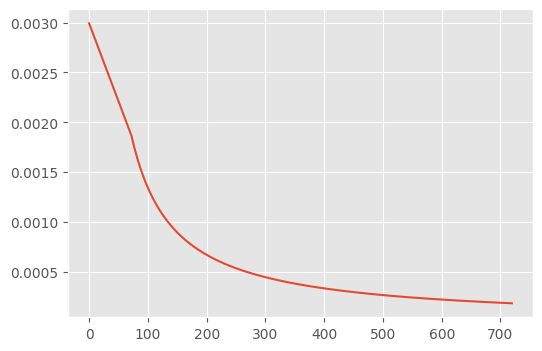

In [33]:
plot_func_fund(604486)

In [183]:
def plot_func_fund_li_nolin(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    #q_max = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 10*k_hat, 1000)

    h = h_param

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid, color = 'red')
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]


    alpha_gridl = a_hatl - b_hatl * q_grid

    #plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_gridl, color='black')

    
    plt.show()

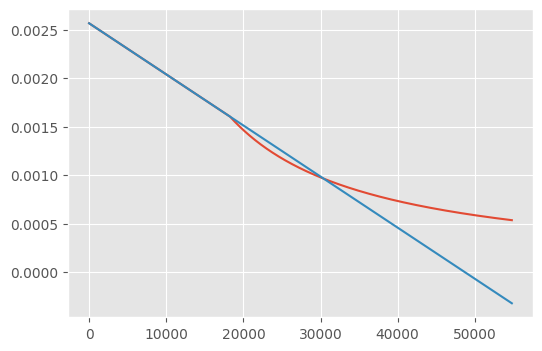

In [102]:
plot_func_fund_li_nolin(105458)

In [36]:
def plot_fit_fund_li_nolin(fundID):

    g = df[df["fund_id"] == fundID].sort_values("time")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    h = h_param

    y_hat_nl = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) + F.dot(beta_hat).flatten()

    y_hat_lin = (a_hatl - b_hatl * q) + F.dot(beta_hatl).flatten()

    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl, y, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin, y, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Actual Y")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();
    
    plt.show()

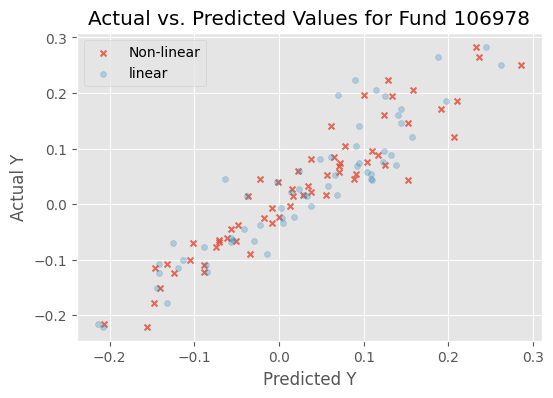

In [37]:
plot_fit_fund_li_nolin(106978)

In [195]:
def plot_fit_fund_li_nolin_subsBeta(fundID):

    g = df[df["fund_id"] == fundID].sort_values("TNA")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    q_grid = np.linspace(0.0001, q.max(), 10000)

    y_subs = y - F.dot(beta_hat).flatten()
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    y_subsl = y - F.dot(beta_hatl).flatten()

    h = h_param

    y_hat_nl_subs = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) 

    y_hat_lin_subs = (a_hatl - b_hatl * q) 

    plt.figure(figsize=(6,4))
    #plt.scatter(q, y, s=18, alpha= 0.3, marker="x", label= "Y ")
    plt.scatter(q, y_subs, s=18, alpha= 0.3, label= "")
    
    plt.plot(q,y_hat_nl_subs, color = 'red')
    plt.plot(q,y_hat_lin_subs, color = 'black')

     
    median_tna = np.median(q)
    plt.axvline(x=median_tna, color='red', linestyle='--', label=f'Median size ({median_tna:.2f})')
    

    #plt.xlabel("q")
    plt.ylabel("Gross alpha")
    #plt.title(f"Values for Fund {fundID}")
    plt.legend();
    
    plt.show()



    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl_subs, y_subs, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin_subs, y_subsl, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Y - F dot beta")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();

    
    plt.show()

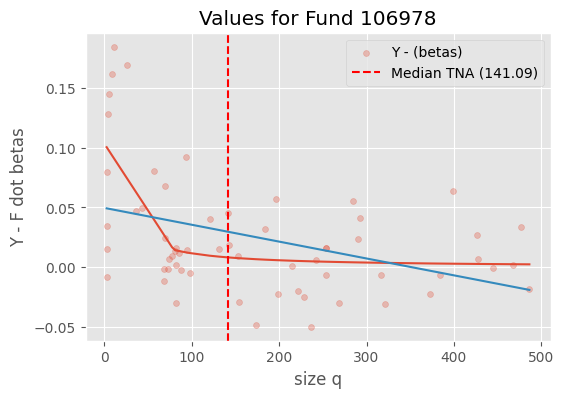

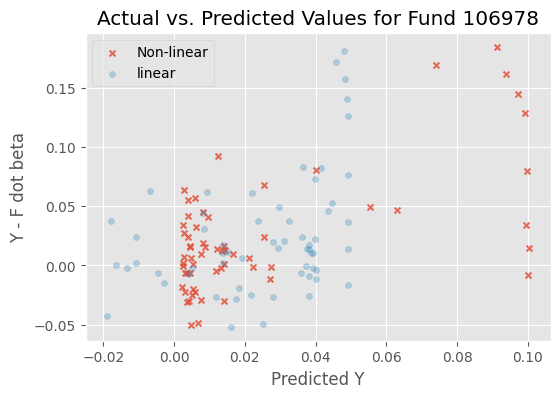

In [39]:
plot_fit_fund_li_nolin_subsBeta(106978)

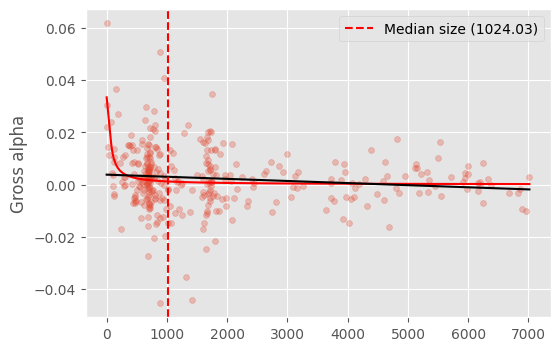

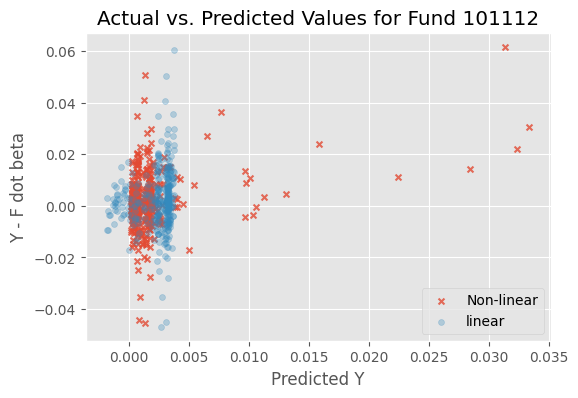

In [196]:
plot_fit_fund_li_nolin_subsBeta(101112)

Excel with results of both specifications

In [41]:
sheet = (estimates_lin[["fund_id", "a_lin", "b_lin"]]
         .merge(estimates[["fund_id", "a", "b", "K"]], on="fund_id")
         .rename(columns={"a":"a_nlin", "b":"b_nl"}))

In [42]:
sheet.to_excel("AllFundsBothSpecifications.xlsx", index=False)

Results for funds with positive a nd b in the linear fit

In [43]:
est_lin_pos = estimates_lin.query("a_lin >= 0 and b_lin > 0").copy()
#est_nl_pos = estimates.query("a >= 0 and b > 0").copy()

In [44]:
est_nl_pos = estimates[estimates.fund_id.isin(set(est_lin_pos.fund_id))]
est_nl_pos

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory
1,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003,1357.875385
2,0.003189,-6.335528e-05,125.260349,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.171079
3,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006,5700.289747
4,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009,39.087742
5,0.005639,2.637993e-06,4275.044336,0.836585,0.057675,0.165395,0.050502,0.059362,True,341,0.895250,100010,1068.760810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312,5.834739,5.018028e-01,11.624402,0.974522,0.839005,0.304324,-0.150545,0.004365,True,63,0.968995,603034,5.813777
2313,0.007503,1.281791e-04,64.531212,0.966205,0.038573,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266025
2314,0.001418,7.012831e-07,2022.539647,0.927379,0.285378,-0.279294,-0.046574,0.003748,True,63,0.955661,603044,1011.269590
2316,-0.024602,-1.281383e-03,24.458271,0.811514,1.081590,-0.039676,0.017651,0.003783,True,62,0.967296,603104,9.599884


In [45]:
df_positive = df[df.fund_id.isin(set(est_lin_pos.fund_id))]

In [46]:
df_single_fund = df_positive
df_single_fund["fund_id"] = 1
df_single_fund

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/976209813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_fund["fund_id"] = 1


,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
517584,223,1,1,0.046934,8.809140,0,0,0,0,0,...,0,0,0,0,0,1.0,0.035443,0.005237,-0.005185,0.0258
519905,224,1,1,0.048822,23.466464,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.010269,0.035889,0.007661,0.0341
522226,225,1,1,-0.010571,40.921777,0,0,0,0,0,...,0,0,0,0,0,1.0,0.018486,0.005064,-0.026427,-0.0267
524547,226,1,1,-0.030343,59.166951,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.012031,-0.023049,-0.011480,-0.0471
526868,227,1,1,0.049696,73.954055,0,0,0,0,0,...,0,0,0,0,0,1.0,0.009790,0.022080,0.000757,0.0229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241733,534,2319,1,0.002004,48.114893,0,0,0,0,0,...,0,0,0,0,0,1.0,0.012473,-0.008616,-0.013872,0.0272
1244054,535,2319,1,-0.002624,48.052107,0,0,0,0,0,...,0,0,0,0,0,1.0,-0.017441,-0.033533,-0.021151,0.0766
1246375,536,2319,1,0.030620,47.881574,0,0,0,0,0,...,0,0,0,0,0,1.0,0.016911,0.002096,0.037129,-0.0685
1248696,537,2319,1,0.016188,45.260159,0,0,0,0,0,...,0,0,0,0,0,1.0,0.020159,0.004677,-0.013553,0.0029


In [47]:
estimates_single_fund = estimate_all_funds(df_single_fund)
estimates_single_fund

  0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

benchmark discounted R2

In [48]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)








In [49]:
def alpha_lin_gauss(a, b, K, q, h):
    
    return (a - b*q)

In [50]:
def add_gross_alpha_R2(estimates_df, method):
    
    r2_values = []

    for fid in estimates_df["fund_id"]:

        g = df[df["fund_id"] == fid].sort_values("TNA")
        q = g["TNA"].to_numpy(float)
        y = g["Y"].to_numpy(float)
        F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)
    
        a = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 0]
        b = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 1]
        k = estimates_df.loc[estimates_df["fund_id"] == fid].iloc[0, 2]

        beta_col = [c for c in estimates_df.columns if c.startswith("beta")]
        beta = estimates_df.loc[estimates_df["fund_id"] == fid, beta_col].to_numpy(float).reshape(-1, 1)

        y_subs = y - F.dot(beta).flatten()

        h = h_param

        y_hat_subs = method(a, b, k, q, h) 


        # R2 = 1 - (sum of squares of residuals) / (total sum of squares)
        ss_total = np.sum((y_subs - np.mean(y_subs)) ** 2)
        ss_residual = np.sum((y_subs - y_hat_subs) ** 2)

        r_squared = 1 - (ss_residual / ss_total)

        r2_values.append({"fund_id": fid, "r_squared": r_squared})

    r2_df = pd.DataFrame(r2_values)
    
    estimates_df = pd.merge(estimates_df, r2_df, on="fund_id", how="left")

    return estimates_df
    

In [51]:
est_lin_pos_gross_r2 = add_gross_alpha_R2(est_lin_pos, alpha_lin_gauss)

In [52]:
est_lin_pos_gross_r2

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id,r_squared
0,0.004300,1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,1357.875384,100003,0.000577
1,0.004346,1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,1487.950849,100004,0.003646
2,0.006741,5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,5700.289753,100006,0.018171
3,0.007891,1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,220.759662,100009,0.004509
4,0.005639,2.637993e-06,0.836585,0.057675,0.165395,0.050502,0.790500,0.118724,341,1068.760811,100010,0.004026
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0.010257,4.415307e-04,0.972123,0.838933,0.289786,-0.149562,0.938669,0.008634,63,11.615427,603034,0.013772
1770,0.001456,4.801583e-06,0.965359,0.038410,0.193675,0.028285,0.941999,0.003950,63,151.604108,603041,0.001731
1771,0.001418,7.012831e-07,0.927379,0.285378,-0.279294,-0.046574,0.911322,0.007496,63,1011.269566,603044,0.000077
1772,0.007462,8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,44.154539,603104,0.016082


In [53]:
est_nl_pos_gross_r2 = add_gross_alpha_R2(est_nl_pos, alpha_smooth_gauss)

In [54]:
est_nl_pos_gross_r2

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003,1357.875385,0.000577
1,0.003189,-6.335528e-05,125.260349,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004,-25.171079,0.027115
2,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006,5700.289747,0.018171
3,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009,39.087742,0.023519
4,0.005639,2.637993e-06,4275.044336,0.836585,0.057675,0.165395,0.050502,0.059362,True,341,0.895250,100010,1068.760810,0.004026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,5.834739,5.018028e-01,11.624402,0.974522,0.839005,0.304324,-0.150545,0.004365,True,63,0.968995,603034,5.813777,0.002381
1770,0.007503,1.281791e-04,64.531212,0.966205,0.038573,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266025,0.036292
1771,0.001418,7.012831e-07,2022.539647,0.927379,0.285378,-0.279294,-0.046574,0.003748,True,63,0.955661,603044,1011.269590,0.000077
1772,-0.024602,-1.281383e-03,24.458271,0.811514,1.081590,-0.039676,0.017651,0.003783,True,62,0.967296,603104,9.599884,0.027403


In [55]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.022421
R2_gross_nl       0.034022
R2_gross_delta    0.011601
dtype: float64

In [56]:
cmp1 = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp1["K_delta"] = cmp1["K"] - cmp1["K_theory"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp1[["K_delta", "K", "K_theory"]].mean()
len(cmp1)

delta = nl - lin, only for a,b>0 in the lin spec


1774

Positive a and b in the non linear specification

In [57]:
est_nl_pos_gross_r2_nonLinearPositive = est_nl_pos_gross_r2.query("a >= 0 and b > 0").copy()
est_nl_pos_gross_r2_nonLinearPositive.shape

(1405, 14)

In [58]:
cmp = (est_lin_pos_gross_r2[["fund_id", "r_squared", "K_the_lin"]].rename(columns={"r_squared":"R2_gross_lin"})).merge(est_nl_pos_gross_r2_nonLinearPositive[["fund_id", "r_squared","K","K_theory"]].rename(columns={"r_squared":"R2_gross_nl"}), on="fund_id", how="inner")
cmp["R2_gross_delta"] = cmp["R2_gross_nl"] - cmp["R2_gross_lin"]
print("delta = nl - lin, only for a,b>0 in the lin spec")
cmp[["R2_gross_lin", "R2_gross_nl", "R2_gross_delta"]].mean()

delta = nl - lin, only for a,b>0 in the lin spec


R2_gross_lin      0.023040
R2_gross_nl       0.035816
R2_gross_delta    0.012777
dtype: float64

In [59]:
cmp["K_delta"] = cmp["K"] - cmp["K_theory"]
print("delta = nl - theoretical, only for a,b>0 in both specifications")
print(cmp[["K_delta", "K", "K_theory"]].mean())
print(cmp[["K_delta", "K", "K_theory"]].std())

delta = nl - theoretical, only for a,b>0 in both specifications
K_delta      689.098252
K           2360.618046
K_theory    1671.519794
dtype: float64
K_delta     5228.874761
K           7670.334732
K_theory    6313.281733
dtype: float64


In [60]:
cmp['K_theory'].idxmax()

1072

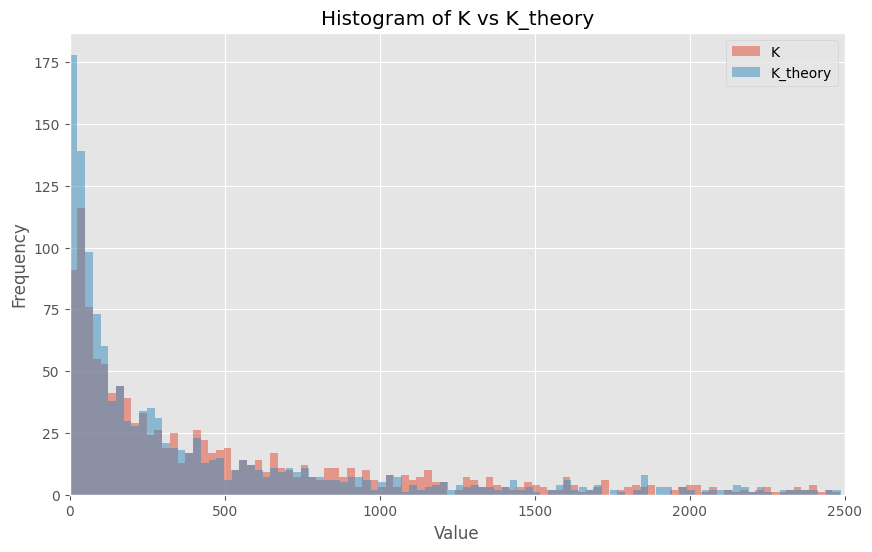

In [61]:
plt.figure(figsize=(10, 6))

filter1 = cmp[cmp['K'] < 2500]
filter2 = cmp[cmp['K_theory'] < 2500]

plt.hist(filter1['K'], bins=100, alpha=0.5, label='K')
plt.hist(filter2['K_theory'], bins=100, alpha=0.5, label='K_theory')

plt.title('Histogram of K vs K_theory')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(0, 2500)
plt.legend()
plt.savefig('k_vs_k_theory_histograms.png')

In [84]:
cmp.loc[cmp['R2_gross_nl'].idxmax()]

fund_id           106978.000000
R2_gross_lin           0.155199
K_the_lin            175.771121
R2_gross_nl            0.391000
K                     79.367289
K_theory              46.200434
R2_gross_delta         0.235801
K_delta               33.166856
Name: 780, dtype: float64

In [63]:
est_nl_pos_gross_r2_nonLinearPositive

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id,K_theory,r_squared
0,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,0.933138,100003,1357.875385,0.000577
2,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,0.953960,100006,5700.289747,0.018171
3,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,277,0.912045,100009,39.087742,0.023519
4,0.005639,2.637993e-06,4275.044336,0.836585,0.057675,0.165395,0.050502,0.059362,True,341,0.895250,100010,1068.760810,0.004026
5,0.004523,1.712307e-05,334.146943,0.960023,-0.045434,-0.335320,0.108220,0.009412,True,242,0.980851,100016,132.066224,0.023450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,0.006138,7.405032e-06,718.750998,0.852504,0.124212,0.239512,-0.081948,0.005515,True,65,0.922636,602953,414.449538,0.017702
1769,5.834739,5.018028e-01,11.624402,0.974522,0.839005,0.304324,-0.150545,0.004365,True,63,0.968995,603034,5.813777,0.002381
1770,0.007503,1.281791e-04,64.531212,0.966205,0.038573,0.183228,0.025996,0.001907,True,63,0.971991,603041,29.266025,0.036292
1771,0.001418,7.012831e-07,2022.539647,0.927379,0.285378,-0.279294,-0.046574,0.003748,True,63,0.955661,603044,1011.269590,0.000077


9.261241446651735e-293
243.50650447296357
1.46529403192867


/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2773813157.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


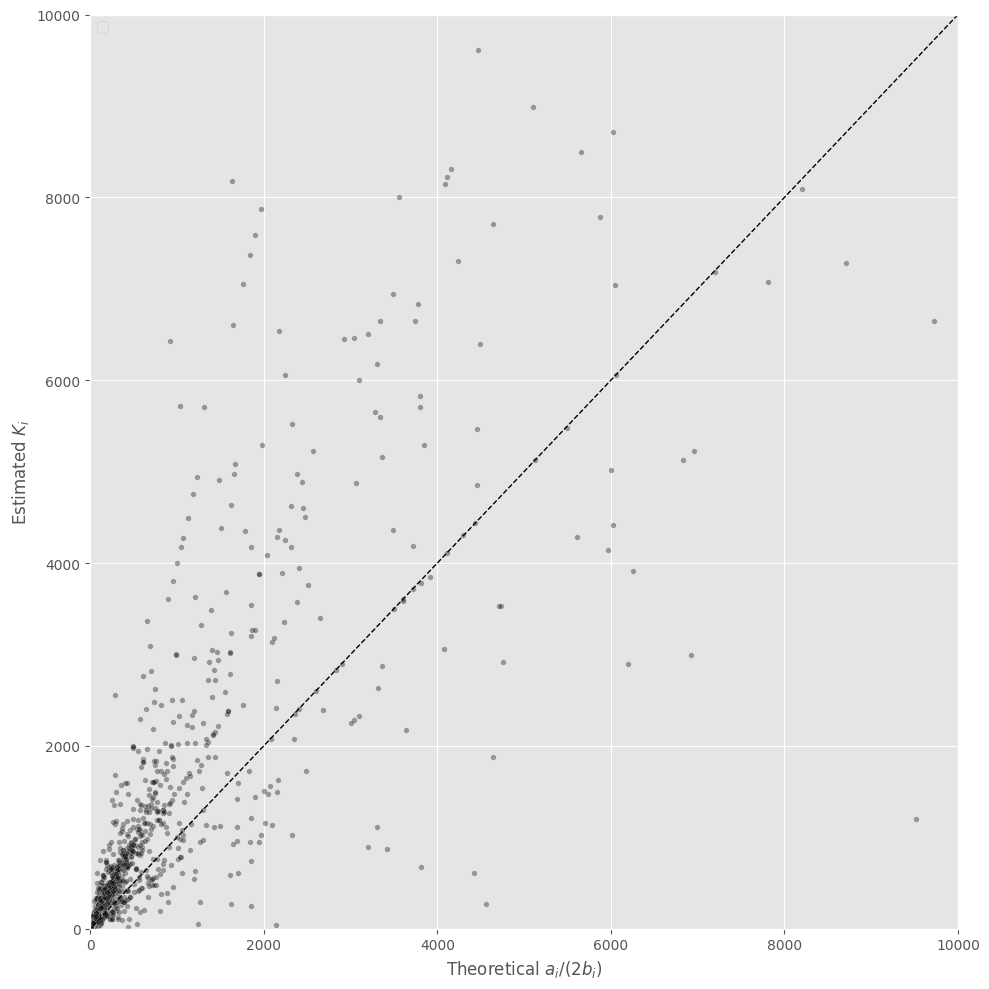

In [92]:
plt.figure(figsize=(10,10))



sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive, x="K_theory", y="K",s=16, alpha=0.35, color='black')

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()

plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(0, 10000); plt.ylim(0, 10000)

# Calculate the 99th percentile of the 'K_theory' column
k_theory_95th_percentile = np.percentile(cmp['K_theory'], 99)

# Filter the DataFrame to include only rows where 'K_theory' is within the limit
filtered_k_theory = cmp[cmp['K_theory'] <= k_theory_95th_percentile]['K_theory']
filtered_k = cmp[cmp['K_theory'] <= k_theory_95th_percentile]['K']

# --- Perform Linear Regression with Statsmodels to get p-value ---
# Add a constant (intercept) to the independent variable
X = sm.add_constant(filtered_k_theory)
y = filtered_k

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X)
results = model.fit()

# Extract the slope and p-value for the K_theory variable
slope = results.params['K_theory']
p_value = results.pvalues['K_theory']
intercept = results.params['const']
print(p_value)
print(intercept)
print(slope)

# Perform polyfit on the filtered data
#slope, intercept = np.polyfit(filtered_k_theory, filtered_k, 1)
# Plot the best-fit line
#plt.plot(est_nl_pos_gross_r2_nonLinearPositive['K_theory'], slope * est_nl_pos_gross_r2_nonLinearPositive['K_theory'] + intercept, color='red', linestyle='-', alpha=0.25, lw=2, label='Line of Best Fit for 95% percentile')

# Add the legend to display the new line's label
plt.legend()


plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
#plt.title(r"$K$ vs Theoretical $a/(2b)$")
plt.tight_layout()
plt.show()

Analysis per percentiles

In [67]:
# Count the number of funds where 'K_theory' is greater than the 99th percentile
dropped_funds_direct = len(cmp[cmp['K_theory'] > k_theory_95th_percentile])
print(f"Funds dropped (direct method): {dropped_funds_direct}")

Funds dropped (direct method): 71


In [68]:
# Assuming 'cmp' DataFrame is already loaded and available.
# This code will produce a table summarizing the mean values for different percentiles.

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory"]].mean()
    
    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K Mean': mean_values['K'],
        'K_theory Mean': mean_values['K_theory'],
        'Difference': mean_values['K_delta']
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile       K Mean  K_theory Mean  Difference
0        50%   158.493705      76.644296   81.849409
1        80%   476.576405     251.981654  224.594751
2        90%   778.536221     433.071613  345.464608
3        95%  1127.008293     635.100471  491.907822
4        99%  1954.988969    1168.012991  786.975978


/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2783664472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2783664472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2783664472.py:19: SettingWithCopyWarning: 
A va

In [69]:

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory"]].mean()
    
    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K Mean': mean_values['K'],
        'K_theory Mean': mean_values['K_theory'],
        'K_difference': mean_values['K_delta'],
        'Funds Included': len(filtered_cmp) # New column to count the funds
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile       K Mean  K_theory Mean  K_difference  Funds Included
0        50%   158.493705      76.644296     81.849409             703
1        80%   476.576405     251.981654    224.594751            1124
2        90%   778.536221     433.071613    345.464608            1264
3        95%  1127.008293     635.100471    491.907822            1334
4        99%  1954.988969    1168.012991    786.975978            1390


/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/199213775.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/199213775.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/199213775.py:16: SettingWithCopyWarning: 
A value

In [70]:

# Define the percentiles to analyze
percentiles = [50, 80, 90, 95, 99, 100]

# Create an empty list to store the results for each percentile
results = []

# Loop through each percentile
for p in percentiles:
    # Calculate the percentile value of 'K_theory'
    k_theory_percentile = np.percentile(cmp['K_theory'], p)
    
    # Filter the DataFrame based on the current percentile
    filtered_cmp = cmp[cmp['K_theory'] <= k_theory_percentile]
    
    # Calculate the 'K_delta' for the filtered data
    filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
    
    # Calculate the mean of the relevant columns
    mean_values = filtered_cmp[["K_delta", "K", "K_theory", "R2_gross_nl", "R2_gross_lin"]].mean()
    std_values = filtered_cmp[["K_delta", "K", "K_theory", "R2_gross_nl", "R2_gross_lin"]].std()


    # Create a dictionary to hold the results for this percentile
    result_dict = {
        'Percentile': f"{p}%",
        'K avg': mean_values['K'],
        'K theory avg': mean_values['K_theory'],
        'K difference': mean_values['K_delta'],
        'K standard deviation': std_values['K'],
        'K theory deviation': std_values['K_theory'],
        'Kdelta standard deviation': std_values['K_delta'],
        'Non-linear R2': mean_values['R2_gross_nl'],
        'Linear R2': mean_values['R2_gross_lin'],

        'Funds Included': len(filtered_cmp), # New column to count the funds
        'Funds K>K theory': len(filtered_cmp[filtered_cmp['K'] > filtered_cmp['K_theory']])
    }
    
    # Add the dictionary to our results list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame for a clean table output
results_df = pd.DataFrame(results)

# Print the final table
print(results_df)

  Percentile        K avg  K theory avg  K difference  K standard deviation  \
0        50%   158.493705     76.644296     81.849409            153.086964   
1        80%   476.576405    251.981654    224.594751            650.097042   
2        90%   778.536221    433.071613    345.464608           1305.560800   
3        95%  1127.008293    635.100471    491.907822           2480.165213   
4        99%  1954.988969   1168.012991    786.975978           5808.441274   
5       100%  2360.618046   1671.519794    689.098252           7670.334732   

   K theory deviation  Kdelta standard deviation  Non-linear R2  Linear R2  \
0           62.801010                 107.376876       0.047832   0.028325   
1          279.723535                 463.211880       0.040209   0.025140   
2          601.568137                 909.951546       0.038042   0.024079   
3         1056.946157                1831.139506       0.037012   0.023599   
4         3117.567983                3869.646025       0

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2034158601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2034158601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cmp["K_delta"] = filtered_cmp["K"] - filtered_cmp["K_theory"]
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/2034158601.py:16: SettingWithCopyWarning: 
A va

In [71]:
len(cmp[cmp['K'] > cmp['K_theory']])

1157

Decile and style analysis

In [ ]:
# Assuming your DataFrame is named 'df'
style_cols = [f'style_{i}' for i in range(1, 19)]

# Calculate the sum of the style columns for each fund
# We will use .loc to avoid a SettingWithCopyWarning if 'df' is a slice
df.loc[:, 'style_sum'] = df.loc[:, style_cols].sum(axis=1)

# Get the fund IDs for the funds with a style sum of 0
funds_with_no_style = df[df['style_sum'] == 0]['fund_id'].unique()

In [73]:
# Count the number of unique funds with no style
num_funds_with_no_style = len(funds_with_no_style)

print(f"Number of funds that lack a style: {num_funds_with_no_style} 🔎")
print("Fund IDs of funds with no style:")
print(funds_with_no_style)

Number of funds that lack a style: 802 🔎
Fund IDs of funds with no style:
[100004 100006 100010 100017 100022 100030 100046 100047 100068 100076
 100097 100098 100099 100111 100127 100150 100160 100222 100228 100250
 100259 100275 100280 100287 100290 100298 100299 100305 100313 100324
 100333 100344 100350 100351 100358 100365 100395 100398 100399 100401
 100408 100424 100430 100451 100514 100521 100531 100535 100548 100561
 100564 100574 100610 100611 100622 100624 100644 100682 100688 100695
 100697 100698 100700 100705 100714 100715 100727 100740 100741 100756
 100767 100772 100773 100790 100809 100813 100829 100855 100875 100878
 100889 100891 100900 100910 100916 100921 100925 100962 100980 101020
 101023 101045 101055 101061 101068 101069 101079 101080 101081 101082
 101084 101085 101107 101132 101135 101158 101167 101181 101200 101211
 101216 101263 101268 101284 101285 101287 101300 101322 101354 101356
 101357 101358 101360 101364 101390 101397 101399 101400 101414 101457
 10

In [138]:
def estimate_one_fund_des(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:
        # print(q)             # skip tiny time-series
        return None

    # ----- new initial guesses from linear model -----
    fund_id = fund_df["fund_id"].iat[0]

    # Look up the linear model's estimates
    linear_estimates = estimates_lin.loc[estimates_lin["fund_id"] == fund_id]

    # Assign the linear estimates to the initial guess variables
    a0 = linear_estimates["a_lin"].iat[0]
    b0 = linear_estimates["b_lin"].iat[0]
    #K0 = linear_estimates["K_the_lin"].iat[0] 

    K0 = max(linear_estimates["K_the_lin"].iat[0], 1e-6)
    
    #a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

def estimate_all_funds_completeDes(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates and descriptive information for each fund
    """
    results = []
    
    # -------- Step 1: Run all estimations --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_des(g, h)
        if est is not None:
            est["fund_id"] = fid

            # --- Get fund style ---
            style_cols = [f'style_{i}' for i in range(1, 19)]
            fund_styles = g[style_cols].iloc[0]
            
            if (fund_styles == 1).any():
                fund_style = fund_styles[fund_styles == 1].index[0].replace('style_', '')
                est["fund_style"] = fund_style
            else:
                est["fund_style"] = None

            # --- Add individual fund mean and median TNA ---
            est["TNA_mean"] = g['TNA'].mean()
            est["TNA_median"] = g['TNA'].median()
            est["TNA_max"] = g['TNA'].max()

            
            results.append(est)

    estimates = pd.DataFrame(results)
    
    estimates_lin_subset = estimates_lin[['fund_id', 'a_lin', 'b_lin', 'K_the_lin', 'p_value_a', 'p_value_b']].copy()

    estimates = pd.merge(estimates, estimates_lin_subset, on='fund_id', how='left')

    # ---
    estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])
    estimates = add_gross_alpha_R2(estimates, alpha_smooth_gauss)

    # ---
    estimates = estimates[estimates.fund_id.isin(set(est_lin_pos.fund_id))]
    estimates2 = estimates.query("a >= 0 and b > 0").copy()

    
    # ---
    tna_series = estimates2.groupby("fund_id")["TNA_mean"].mean().dropna()
    tna_decile = pd.qcut(tna_series, 10, labels=False, duplicates='drop') + 1
    
    # Add the decile information back to the DataFrame
    estimates2 = estimates2.set_index("fund_id")
    estimates2['tna_decile'] = tna_decile
    estimates2 = estimates2.reset_index()

    return estimates2


In [139]:
est_nl_pos_gross_r2_nonLinearPositive_des = estimate_all_funds_completeDes(df, h =h_param)

100%|██████████| 2321/2321 [00:06<00:00, 334.53it/s]


In [120]:
est_nl_pos_gross_r2_nonLinearPositive_des

,fund_id,a,b,K,beta1,beta2,beta3,beta4,SSE,success,...,fund_style,TNA_mean,TNA_median,TNA_max,a_lin,b_lin,K_the_lin,K_theory,r_squared,tna_decile
0,100003,0.004300,1.583310e-06,2038.510818,1.009327,0.619777,-0.017121,0.039970,0.054565,True,...,9,722.654595,689.533262,1501.150469,0.004300,1.583310e-06,1357.875384,1357.875385,0.000577,8
1,100006,0.006741,5.913177e-07,22801.159251,0.843809,0.142745,0.331572,0.036263,0.011378,True,...,None,2391.626421,907.519798,8079.419237,0.006741,5.913177e-07,5700.289753,5700.289747,0.018171,10
2,100009,0.016977,2.171707e-04,68.816597,1.089420,0.736738,-0.505212,0.147738,0.110326,True,...,3,123.677453,73.046110,475.122640,0.007891,1.787235e-05,220.759662,39.087742,0.023519,3
3,100010,0.005639,2.637993e-06,4275.044336,0.836585,0.057675,0.165395,0.050502,0.059362,True,...,None,489.927207,254.068939,1914.306708,0.005639,2.637993e-06,1068.760811,1068.760810,0.004026,7
4,100016,0.004523,1.712307e-05,334.146943,0.960023,-0.045434,-0.335320,0.108220,0.009412,True,...,18,114.530746,94.568754,410.944094,0.004342,1.511352e-05,143.631180,132.066224,0.023450,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,602953,0.006138,7.405032e-06,718.750998,0.852504,0.124212,0.239512,-0.081948,0.005515,True,...,7,747.107801,759.998667,1229.090939,0.005703,5.360695e-06,531.904398,414.449538,0.017702,8
1401,603034,5.834739,5.018028e-01,11.624402,0.974522,0.839005,0.304324,-0.150545,0.004365,True,...,None,21.869613,21.257924,28.382247,0.010257,4.415307e-04,11.615427,5.813777,0.002381,1
1402,603041,0.007503,1.281791e-04,64.531212,0.966205,0.038573,0.183228,0.025996,0.001907,True,...,13,191.936921,214.661479,262.939416,0.001456,4.801583e-06,151.604108,29.266025,0.036292,5
1403,603044,0.001418,7.012831e-07,2022.539647,0.927379,0.285378,-0.279294,-0.046574,0.003748,True,...,None,282.605853,310.426273,479.532347,0.001418,7.012831e-07,1011.269566,1011.269590,0.000077,5


In [77]:
est_nl_pos_gross_r2_nonLinearPositive_des[["K", "K_theory", "TNA_median", "r_squared"]].mean()

K             2360.618046
K_theory      1671.519794
TNA_median     782.437364
r_squared        0.035816
dtype: float64

/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_49154/3562904750.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


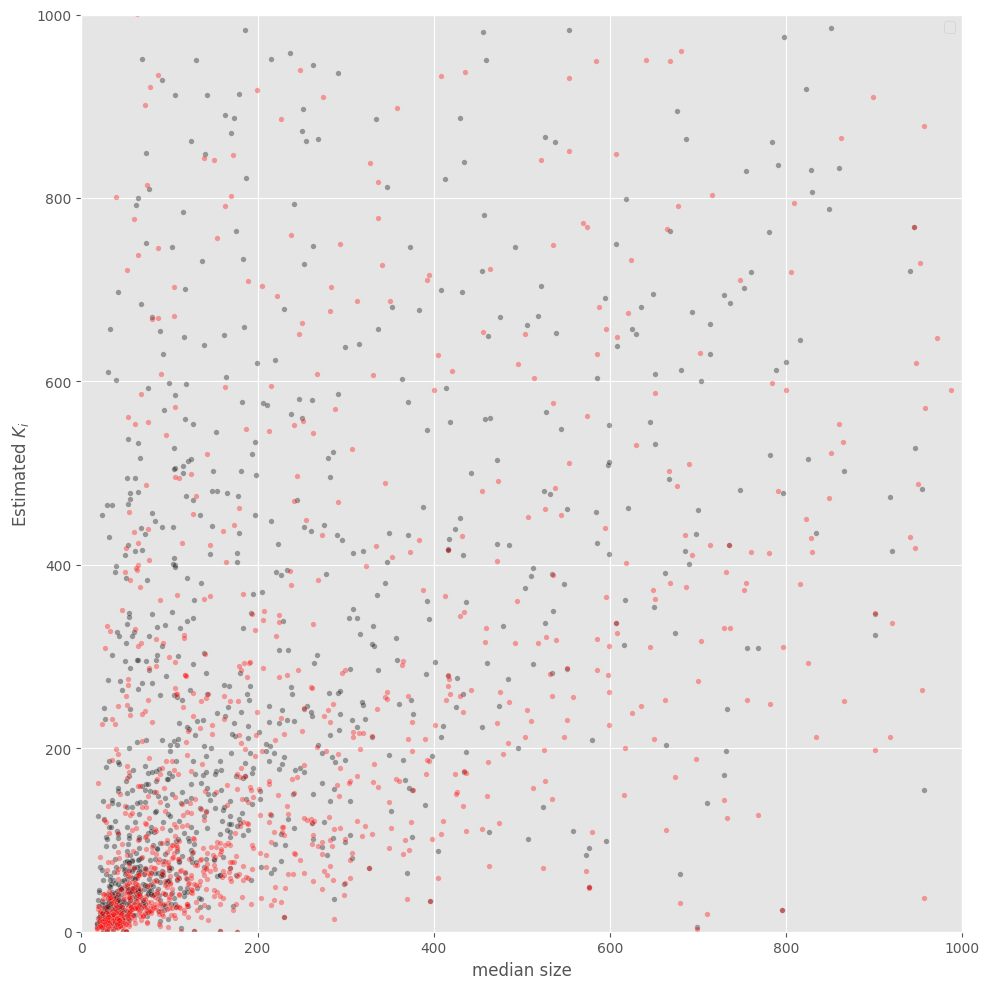

In [78]:
plt.figure(figsize=(10,10))



sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive_des, x="TNA_median", y="K",s=16, alpha=0.35, color='black')
sns.scatterplot(data=est_nl_pos_gross_r2_nonLinearPositive_des, x="TNA_median", y="K_theory",s=16, alpha=0.35, color='red')

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()

#plt.plot(lims, lims, 'k--', lw=1)

#plt.xlim(*lims)
#plt.ylim(*lims)

plt.xlim(0, 1000)
plt.ylim(0, 1000)


plt.legend()


plt.xlabel(r"median size")
plt.ylabel(r"Estimated $K_i$")
#plt.title(r"$K$ vs Theoretical $a/(2b)$")
plt.tight_layout()
plt.show()

Table for deciles of size

In [122]:
cmp_des = est_nl_pos_gross_r2_nonLinearPositive_des.copy()
cmp_des['K_difference'] = cmp_des['K'] - cmp_des['K_theory']


summary_table = cmp_des.groupby('tna_decile').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des[cmp_des['K'] > cmp_des['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

# 4. Format the table for readability
# Set the 'tna_decile' column as the index
summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())



Summary Table of Estimates by Fund Size Decile
               K_avg  K_theory_avg  K_difference    mean_size  Funds_Included  Funds K>K theory
Decile                                                                                         
1          68.507751     37.186795     31.320956    33.624622             141               127
2         204.533726    145.142822     59.390904    58.584379             140               116
3         245.591842    130.524520    115.067322    90.790618             141               124
4         333.599806    202.530337    131.069469   130.530400             140               119
5        1406.785756    826.828933    579.956823   200.181291             141               122
6        1410.878500   1223.266916    187.611584   282.064375             140               108
7        1390.450953    923.274954    467.175999   435.275800             140               116
8        2652.421643   1446.906055   1205.515588   692.604771             141            

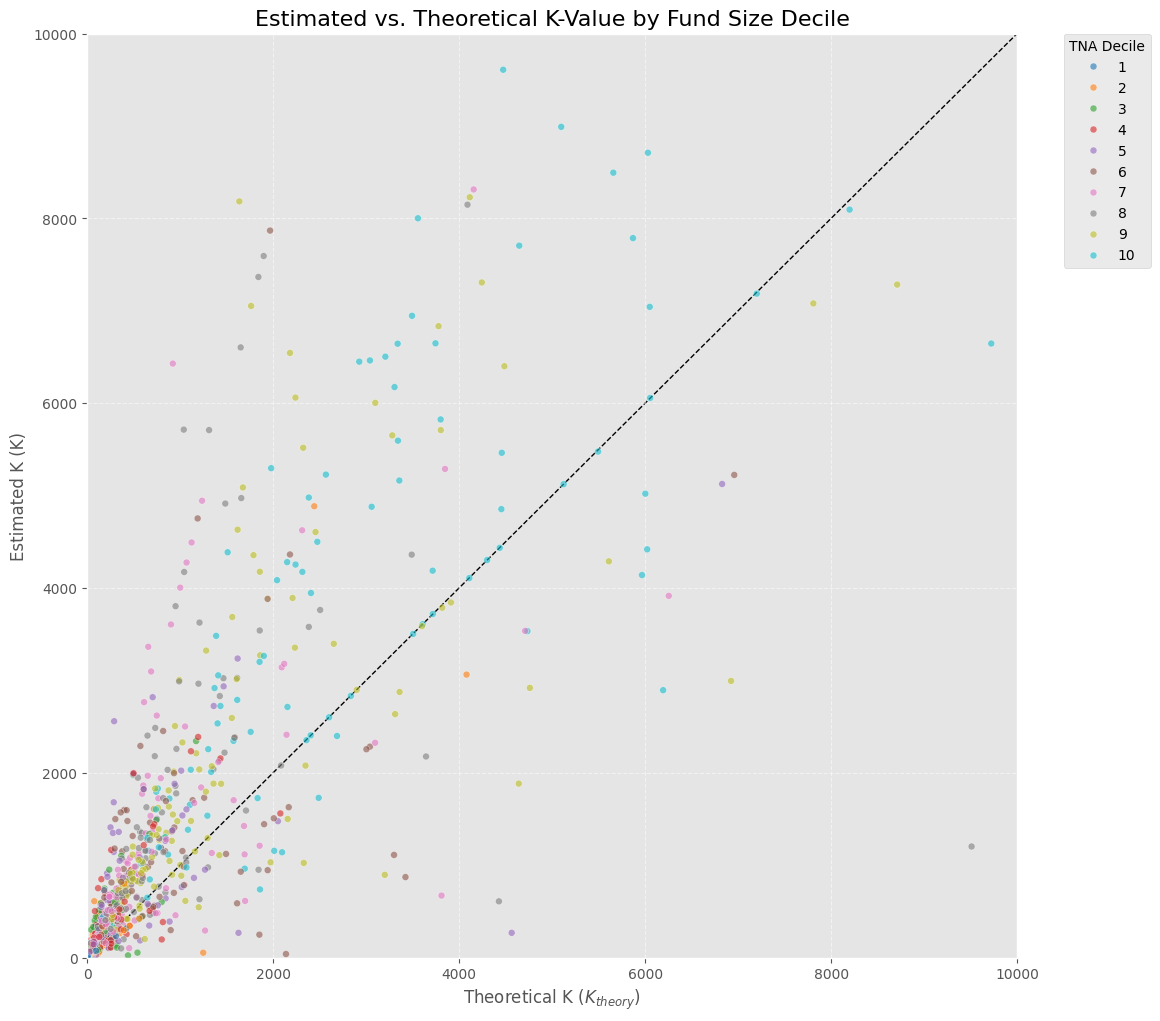

In [80]:
# Create the scatter plot
plt.figure(figsize=(12, 12))

# Use seaborn's scatterplot with 'hue' set to 'tna_decile' to color the points
# The palette 'viridis' is a good choice for continuous data, or a discrete palette
# like 'tab10' for the deciles. We'll use 'viridis' as it scales nicely.
sns.scatterplot(
    data=cmp_des,
    x="K_theory",
    y="K",
    hue="tna_decile",
    palette="tab10",
    s=25, # size of the points
    alpha=0.6 # transparency
)

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1, zorder=0) # zorder to place line behind points

# Set plot limits
plt.xlim(0, 10000)
plt.ylim(0, 10000)

# Add titles and labels
plt.title("Estimated vs. Theoretical K-Value by Fund Size Decile", fontsize=16)
plt.xlabel("Theoretical K ($K_{theory}$)", fontsize=12)
plt.ylabel("Estimated K (K)", fontsize=12)

# Add a legend and a color bar for the hue
plt.legend(title="TNA Decile", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [81]:

summary_table = cmp_des.groupby('fund_style').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    #Linear_R2=('R2_lin', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by style
funds_k_greater_than_k_theory = cmp_des[cmp_des['K'] > cmp_des['K_theory']].groupby('fund_style')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

summary_table.index = pd.to_numeric(summary_table.index)
summary_table = summary_table.sort_index()
summary_table.index.name = 'Style'

# Display the final table
print("Summary Table of Estimates by Fund Style")
print(summary_table.to_string())


Summary Table of Estimates by Fund Style
             K_avg  K_theory_avg  K_difference  Funds_Included  Funds K>K theory
Style                                                                           
1      1061.141089    748.439669    312.701420              25                16
2      2025.839536   1094.224826    931.614710              57                46
3      1349.853229   1591.191138   -241.337909              53                44
4      2259.052574   2025.292955    233.759619              43                29
5       497.865551    277.674153    220.191398              40                36
6      1588.462767    817.178512    771.284255              46                43
7      2724.703989   1708.076914   1016.627075              31                26
8      1145.215693    493.855404    651.360289              36                28
9      2352.644090   1300.957469   1051.686620              53                45
10     3396.511944   3418.433180    -21.921236              29      

In [99]:
# Filter the DataFrame for funds in Style 3 with a negative K_difference
style_3_neg_k_diff_funds = cmp_des[
    (cmp_des['fund_style'] == '3') & (cmp_des['K_difference'] < 0)
].copy()

# Select relevant columns for a detailed look
analysis_table = style_3_neg_k_diff_funds[['fund_id', 'a', 'b', 'TNA_median','K', 'K_theory', 'K_difference']].copy()
analysis_table.set_index('fund_id', inplace=True)

# Print the table
print("Detailed Estimates for Style 3 Funds with Negative K_difference")
print(analysis_table.to_string())

Detailed Estimates for Style 3 Funds with Negative K_difference
                a             b  TNA_median             K      K_theory  K_difference
fund_id                                                                              
100763   0.007819  1.142198e-06  169.571481    870.759338   3422.693882  -2551.934544
102417   0.012718  1.832210e-05  900.303539    346.605555    347.055584     -0.450029
103299   0.005783  1.409701e-07  211.045924    574.729676  20511.378467 -19936.648791
105269   0.003335  2.442116e-07   91.100776   5125.145773   6827.837992  -1702.692219
105458   0.002566  5.272805e-08  415.281951  18267.614498  24336.539345  -6068.924848
106101   0.010531  3.072775e-04   24.397983     17.115410     17.135931     -0.020522
106485   0.007304  2.578713e-05   89.566398     96.415818    141.625632    -45.209814
400127   0.001901  5.124854e-07  485.495748   1209.928173   1854.709090   -644.780918
410447   0.008020  6.169056e-05  117.257686     63.505692     65.000367     

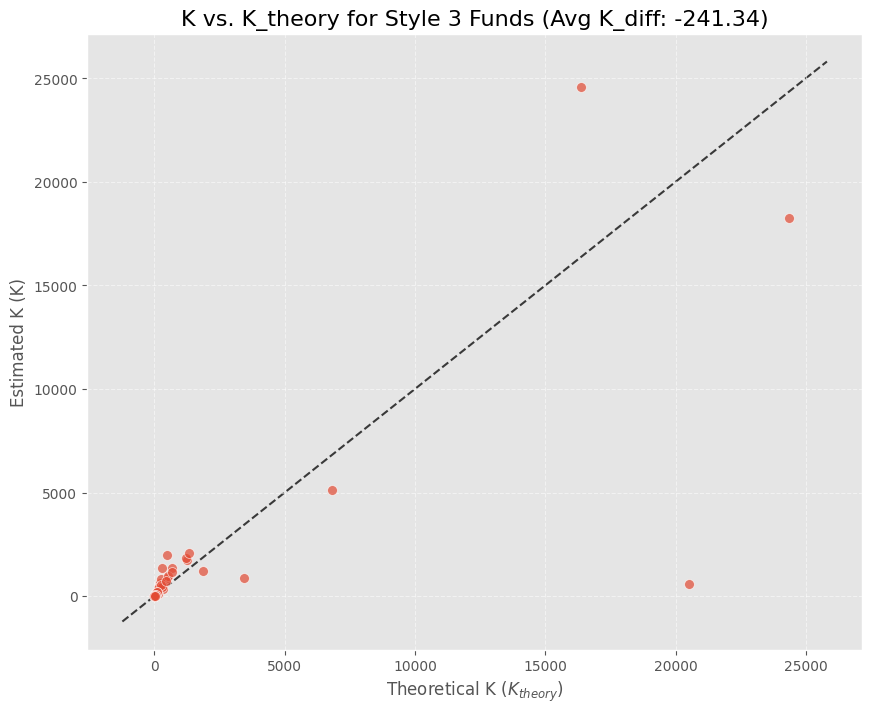

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the average K_difference for the plot title
avg_k_diff = style_3_funds['K_difference'].mean()

# Create the scatter plot for Style 3
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=style_3_funds,
    x='K_theory',
    y='K',
    s=50,
    alpha=0.7
)

# Add the 45-degree reference line
lims = (min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1]))
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# Add titles and labels
plt.title(f'K vs. K_theory for Style 3 Funds (Avg K_diff: {avg_k_diff:.2f})', fontsize=16)
plt.xlabel('Theoretical K ($K_{theory}$)', fontsize=12)
plt.ylabel('Estimated K (K)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [140]:
cmp_des = est_nl_pos_gross_r2_nonLinearPositive_des.copy()
cmp_des['K_difference'] = cmp_des['K'] - cmp_des['K_theory']


summary_table = cmp_des.groupby('tna_decile').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des[cmp_des['K'] > cmp_des['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

funds_k_greater_max_size = cmp_des[cmp_des['K'] < cmp_des['TNA_max']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds $K< max_t(q_{i,t})$ '] = funds_k_greater_max_size



summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())


Summary Table of Estimates by Fund Size Decile
               K_avg  K_theory_avg  K_difference    mean_size  Funds_Included  Funds K>K theory  Funds $K< max_t(q_{i,t})$ 
Decile                                                                                                                     
1          68.507751     37.186795     31.320956    33.624622             141               127                         110
2         204.533726    145.142822     59.390904    58.584379             140               116                         105
3         245.591842    130.524520    115.067322    90.790618             141               124                          98
4         333.599806    202.530337    131.069469   130.530400             140               119                         106
5        1406.785756    826.828933    579.956823   200.181291             141               122                          99
6        1410.878500   1223.266916    187.611584   282.064375             140        

In [161]:
cmp_des_sized = cmp_des[cmp_des['K'] > cmp_des['TNA_max']].copy()

cmp_des_sized['K_difference'] = cmp_des_sized['K'] - cmp_des_sized['K_theory']


summary_table = cmp_des_sized.groupby('tna_decile').agg(
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des_sized[cmp_des_sized['K'] > cmp_des_sized['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory


summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())


Summary Table of Estimates by Fund Size Decile
               K_avg  K_theory_avg  K_difference    mean_size  Funds_Included  Funds K>K theory
Decile                                                                                         
1         212.915146    113.846985     99.068161    35.924400              31                26
2         638.144018    444.605053    193.538965    59.444285              35                23
3         594.355050    278.987953    315.367097    93.382412              43                39
4         866.894358    500.047002    366.847355   139.067997              34                28
5        4147.884641   2276.837977   1871.046665   200.382722              42                35
6        4016.462637   2903.899228   1112.563409   297.676159              39                29
7        4038.666565   2541.390018   1497.276548   420.382984              34                28
8        8960.323355   4144.166350   4816.157005   670.206190              31            

a and b analysis

In [ ]:
cmp_des_s = cmp_des[cmp_des['K'] > cmp_des['TNA_max']].copy()
cmp_des_s['K_difference'] = cmp_des_s['K'] - cmp_des_s['K_theory']


summary_table = cmp_des_s.groupby('tna_decile').agg(
    a_lin_avg=('a_lin', 'mean'),
    a_avg=('a', 'mean'),
    #a_lin_std=('a_lin', 'std'),
    #a_std=('a', 'std'),

    b_lin_avg=('b_lin', 'mean'),
    b_avg=('b', 'mean'),
    #b_std_avg=('b_lin', 'std'),

    #a_p_val=('p_value_a', 'mean'),
    b_p_val=('p_value_b', 'mean'),
    
    #K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    Max_size_avg=('TNA_max', 'mean'),
    #K_difference=('K_difference', 'mean'),
    #mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des_s[cmp_des_s['K'] > cmp_des_s['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

# 4. Format the table for readability
# Set the 'tna_decile' column as the index
summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())



Summary Table of Estimates by Fund Size Decile
        a_lin_avg     a_avg  a_lin_std     a_std     b_lin_avg         b_avg     b_std_avg   a_p_val   b_p_val  K_theory_avg  Max_size_avg  Funds_Included  Funds K>K theory
Decile                                                                                                                                                                      
1        0.005717  0.005717   0.003364  0.003364  6.754367e-05  6.754367e-05  9.297880e-05  0.167714  0.547922    113.846985     80.231243              31                26
2        0.004145  0.004145   0.002489  0.002489  1.882721e-05  1.882721e-05  2.752263e-05  0.195886  0.674023    444.605053    170.834932              35                23
3        0.006704  0.006704   0.003743  0.003743  2.640011e-05  2.640011e-05  4.292075e-05  0.078723  0.448209    278.987953    272.852514              43                39
4        0.006491  0.006491   0.003959  0.003959  1.518599e-05  1.518599e-05  2.017742e-

In [ ]:
# Filter the DataFrame for funds in Style 3 with a negative K_difference
style_3_neg_k_diff_funds = cmp_des_s[
    (cmp_des_s['tna_decile'] == 1) #& (cmp_des['K_difference'] < 0)
].copy()

# Select relevant columns for a detailed look
analysis_table = style_3_neg_k_diff_funds[['fund_id', 'a', 'b', 'a_lin','TNA_median','K', 'K_theory', 'K_difference']].copy()
analysis_table.set_index('fund_id', inplace=True)

# Print the table
print("Detailed Estimates for decile 3 Funds")
print(analysis_table.to_string())

Detailed Estimates for decile 3 Funds
                a         b     a_lin  TNA_median           K    K_theory  K_difference
fund_id                                                                                
100022   0.008602  0.000157  0.008602   40.339584  109.954214   27.473103     82.481111
100250   0.015508  0.000173  0.015508   30.808836  113.974466   44.710278     69.264187
100624   0.006185  0.000017  0.006185   51.443114  135.786467  180.897841    -45.111374
100723   0.003914  0.000026  0.003914   34.308578  301.933610   75.478163    226.455448
101251   0.005208  0.000087  0.005208   38.281598  120.219454   30.044560     90.174894
101557   0.002942  0.000006  0.002942   34.163856  464.754662  232.376506    232.378156
101921   0.005927  0.000085  0.005927   31.891852   61.092994   34.904320     26.188674
102132   0.003684  0.000006  0.003684   32.694633  656.701462  328.349827    328.351635
102173   0.005325  0.000065  0.005325   34.636051  144.013364   41.137218    102.8

In [165]:
cmp_des_s = cmp_des[cmp_des['K'] < cmp_des['TNA_max']].copy()
cmp_des_s['K_difference'] = cmp_des_s['K'] - cmp_des_s['K_theory']


summary_table = cmp_des_s.groupby('tna_decile').agg(
    a_lin_avg=('a_lin', 'mean'),
    a_avg=('a', 'mean'),

    #a_lin_std=('a_lin', 'std'),
    #a_std=('a', 'std'),

    b_lin_avg=('b_lin', 'mean'),
    b_avg=('b', 'mean'),
    #b_std_avg=('b_lin', 'std'),

    #a_p_val=('p_value_a', 'mean'),
    #b_p_val=('p_value_b', 'mean'),
    
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    Max_size_avg=('TNA_max', 'mean'),
    #K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des_s[cmp_des_s['K'] > cmp_des_s['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

# 4. Format the table for readability
# Set the 'tna_decile' column as the index
summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())



Summary Table of Estimates by Fund Size Decile
        a_lin_avg      a_avg     b_lin_avg     b_avg        K_avg  K_theory_avg  Max_size_avg    mean_size  Funds_Included  Funds K>K theory
Decile                                                                                                                                      
1        0.009074   0.290702  2.005964e-04  0.040090    27.811122     15.582560     78.920319    32.976503             110               101
2        0.007770   0.271527  7.468451e-05  0.039647    59.996963     45.322079    176.859552    58.297744             105                93
3        0.007067   0.022995  3.819980e-05  0.003093    92.563088     65.382402    293.902602    89.653402              98                85
4        0.007568   0.457151  2.791447e-05  2.261319   162.543063    107.100464    462.601803   127.791926             106                91
5        0.006923   2.414604  1.587479e-05  0.020323   243.895319    211.673581    711.517885   200.095835 

cleaning spurious cases

In [171]:
# Create cmp_des_s and add K_difference
cmp_des_s = cmp_des[cmp_des['K'] < cmp_des['TNA_max']].copy()
cmp_des_s['K_difference'] = cmp_des_s['K'] - cmp_des_s['K_theory']

# --- New Filtering Step ---
# Remove funds where a or b are greater than 1 to filter spurious cases
cmp_des_s = cmp_des_s[(cmp_des_s['a'] <= 1) & (cmp_des_s['b'] <= 1)].copy()
# --- End of New Filtering Step ---

summary_table = cmp_des_s.groupby('tna_decile').agg(
    a_lin_avg=('a_lin', 'mean'),
    a_avg=('a', 'mean'),

    #a_lin_std=('a_lin', 'std'),
    a_std=('a', 'std'),

    b_lin_avg=('b_lin', 'mean'),
    b_avg=('b', 'mean'),
    b_std_avg=('b', 'std'),

    #a_p_val=('p_value_a', 'mean'),
    #b_p_val=('p_value_b', 'mean'),
    
    K_avg=('K', 'mean'),
    K_theory_avg=('K_theory', 'mean'),
    Max_size_avg=('TNA_max', 'mean'),
    #K_difference=('K_difference', 'mean'),
    mean_size = ('TNA_median', 'mean'),
    #K_standard_deviation=('K', 'std'),
    #K_theory_deviation=('K_theory', 'std'),
    #Kdelta_standard_deviation=('K_difference', 'std'),
    #Non_linear_R2=('R2', 'mean'),
    Funds_Included=('fund_id', 'count')
)

# 3. Calculate the count of funds where K > K_theory, by decile
funds_k_greater_than_k_theory = cmp_des_s[cmp_des_s['K'] > cmp_des_s['K_theory']].groupby('tna_decile')['fund_id'].count()
summary_table['Funds K>K theory'] = funds_k_greater_than_k_theory

# 4. Format the table for readability
# Set the 'tna_decile' column as the index
summary_table.index.name = 'Decile'

# Display the final table
print("Summary Table of Estimates by Fund Size Decile")
print(summary_table.to_string())

Summary Table of Estimates by Fund Size Decile
        a_lin_avg     a_avg     a_std     b_lin_avg     b_avg  b_std_avg        K_avg  K_theory_avg  Max_size_avg    mean_size  Funds_Included  Funds K>K theory
Decile                                                                                                                                                          
1        0.008923  0.047571  0.091157  1.885916e-04  0.011030   0.059921    28.633884     16.073215     80.682952    33.324958             105                96
2        0.007925  0.034179  0.080192  7.523465e-05  0.003215   0.021159    61.740281     46.800569    176.910491    58.411630             101                89
3        0.007067  0.022995  0.029376  3.819980e-05  0.003093   0.020849    92.563088     65.382402    293.902602    89.653402              98                85
4        0.007625  0.015394  0.016209  2.784131e-05  0.000173   0.000321   165.660818    109.156067    465.232758   127.041920             104      

In [197]:
# Filter the DataFrame for funds in Style 3 with a negative K_difference
style_3_neg_k_diff_funds = cmp_des_s[
    (cmp_des_s['tna_decile'] == 9) #& (cmp_des['K_difference'] < 0)
].copy()

# Select relevant columns for a detailed look
analysis_table = style_3_neg_k_diff_funds[['fund_id', 'a', 'b', 'a_lin', 'b_lin','TNA_median','K', 'K_theory', 'K_difference']].copy()
analysis_table.set_index('fund_id', inplace=True)

# Print the table
print("Detailed Estimates for decile 7 Funds")
print(analysis_table.to_string())

Detailed Estimates for decile 7 Funds
                a             b     a_lin         b_lin   TNA_median            K     K_theory  K_difference
fund_id                                                                                                     
100075   0.008156  3.001397e-06  0.007125  1.384959e-06   945.288931  1881.939433  1358.773588    523.165845
100113   0.012997  1.132028e-05  0.008953  4.610716e-06  1108.600709   804.838776   574.072227    230.766549
100190   0.010903  6.206471e-06  0.007306  2.333118e-06   956.436685  1633.308604   878.374102    754.934502
100207   0.018776  1.101913e-05  0.014329  4.026490e-06  2313.473546  1351.168695   851.963201    499.205494
100292   0.010010  5.711980e-06  0.008323  3.099688e-06  1051.138562  1808.294910   876.187487    932.107423
100567   0.021212  1.187004e-04  0.005617  1.258295e-06   372.104255   157.149129    89.350824     67.798304
100598   0.009356  4.429244e-06  0.007366  1.652739e-06   788.833877   612.955631  1056.11

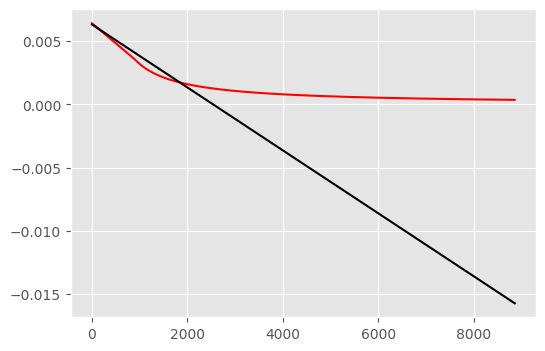

In [206]:
plot_func_fund_li_nolin(302763)

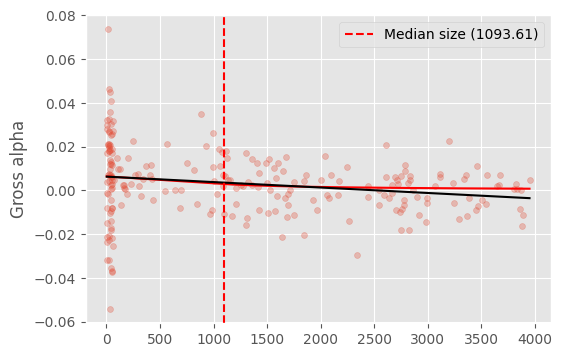

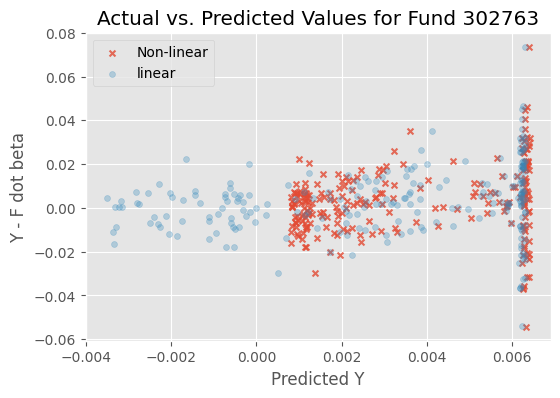

In [207]:
plot_fit_fund_li_nolin_subsBeta(302763)